# BentoML Example: PyTorch Image Classifier

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. In this project we will use BentoML to package the image classifier model, and build a containerized REST API model server.

This notebook was built based on the official pytorch tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=pytorch&ea=pytorch-cifar10-image-classification&dt=pytorch-cifar10-image-classification)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install bentoml
!pip install torch torchvision pillow

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Training an image classifier

We will do the following steps in order:

* Load and normalizing the CIFAR10 training and test datasets using torchvision
* Define a Convolutional Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data
* Model Serving with BentoML


## 1 Loading and Normalizing CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

 ship  frog horse horse


## 2 Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## 3 Define a Loss function and optimize

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4 Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.126
[1,  4000] loss: 1.814
[1,  6000] loss: 1.638
[1,  8000] loss: 1.574
[1, 10000] loss: 1.505
[1, 12000] loss: 1.440
Finished Training


## 5 Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

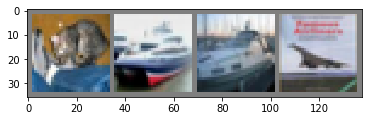

GroundTruth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


# 6 Model Serving with BentoML


First, define ML service with BentoML

In [9]:
%%writefile pytorch_image_classifier.py

from PIL import Image

import torch
from torch.autograd import Variable
from torchvision import transforms

import bentoml
from bentoml.artifact import PytorchModelArtifact
from bentoml.adapters import FileInput


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

@bentoml.env(pip_dependencies=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('net')])
class PytorchImageClassifier(bentoml.BentoService):
    
    @bentoml.utils.cached_property
    def transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    @bentoml.api(input=FileInput())
    def predict(self, file_streams):
        input_datas = []
        for fs in file_streams:
            img = Image.open(fs).resize((32, 32))
            input_datas.append(self.transform(img))

        outputs = self.artifacts.net(Variable(torch.stack(input_datas)))
        _, output_classes = outputs.max(dim=1)

        return [classes[output_class] for output_class in output_classes]

Overwriting pytorch_image_classifier.py


Now you can instantiate a BentoService defined above with the trained model, and save the entire BentoService to a file archive:

In [10]:
# 1) import the custom BentoService defined above
from pytorch_image_classifier import PytorchImageClassifier

# 2) `pack` it with required artifacts
bento_svc = PytorchImageClassifier()
bento_svc.pack('net', net)

# 3) save your BentoSerivce to file archive
saved_path = bento_svc.save()
print(saved_path)

[2020-09-09 11:22:02,880] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-09 11:22:03,291] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService
[2020-09-09 11:22:04,671] INFO - Detected non-PyPI-released BentoML installed, copying local BentoML modulefiles to target saved bundle path..


no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


UPDATING BentoML-0.8.6+34.g6123b8c6/bentoml/_version.py
set BentoML-0.8.6+34.g6123b8c6/bentoml/_version.py to '0.8.6+34.g6123b8c6'
[2020-09-09 11:22:09,796] INFO - BentoService bundle 'PytorchImageClassifier:20200909112204_49F68A' saved to: /Users/bozhaoyu/bentoml/repository/PytorchImageClassifier/20200909112204_49F68A
/Users/bozhaoyu/bentoml/repository/PytorchImageClassifier/20200909112204_49F68A


## BentoService with BentoML CLI

In [11]:
!bentoml get PytorchImageClassifier

BENTO_SERVICE                                 AGE           APIS                              ARTIFACTS
PytorchImageClassifier:20200909112204_49F68A  2.08 seconds  predict<FileInput:DefaultOutput>  net<PytorchModelArtifact>


In [12]:
!bentoml get PytorchImageClassifier:latest

[2020-09-09 11:22:13,546] INFO - Getting latest version PytorchImageClassifier:20200909112204_49F68A
{
  "name": "PytorchImageClassifier",
  "version": "20200909112204_49F68A",
  "uri": {
    "type": "LOCAL",
    "uri": "/Users/bozhaoyu/bentoml/repository/PytorchImageClassifier/20200909112204_49F68A"
  },
  "bentoServiceMetadata": {
    "name": "PytorchImageClassifier",
    "version": "20200909112204_49F68A",
    "createdAt": "2020-09-09T18:22:09.648441Z",
    "env": {
      "condaEnv": "name: bentoml-PytorchImageClassifier\nchannels:\n- conda-forge\n- defaults\ndependencies:\n- python=3.7.3\n- pip\n",
      "pipDependencies": "torch\nbentoml==0.8.6\nnumpy\ntorchvision\nscikit-learn",
      "pythonVersion": "3.7.3",
      "dockerBaseImage": "bentoml/model-server:0.8.6"
    },
    "artifacts": [
      {
        "name": "net",
        "artifactType": "PytorchModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "inputType": "FileInput",
        "docs": "B

In [12]:
!bentoml info PytorchImageClassifier:latest

[2020-08-03 17:56:08,207] INFO - Getting latest version PytorchImageClassifier:20200803175534_4C7106
[2020-08-03 17:56:08,227] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-03 17:56:08,242] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g5daa71b
{
  "name": "PytorchImageClassifier",
  "version": "20200803175534_4C7106",
  "created_at": "2020-08-03T09:55:44.025755Z",
  "env": {
    "conda_env": "name: bentoml-PytorchImageClassifier\nchannels:\n- defaults\ndependencies:\n- python=3.6.10\n- pip\n",
    "pip_dependencies": "torch\nbentoml==0.8.3\nnumpy\ntorchvision\nscikit-learn",
    "python_version": "3.6.10",
    "docker_base_image": "bentoml/model-server:0.8.3"
  },
  "artifacts": [

In [13]:
!bentoml run PytorchImageClassifier:latest predict  --input=bird.jpg

[2020-08-03 17:56:18,947] INFO - Getting latest version PytorchImageClassifier:20200803175534_4C7106
[2020-08-03 17:56:20,021] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-03 17:56:20,038] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g5daa71b
[2020-08-03 17:56:20,832] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService
deer


## Model Serving via REST API

In your termnial, run the following command to start the REST API server:

In [14]:
!bentoml serve PytorchImageClassifier:latest --enable-microbatch

[2020-08-03 17:56:58,854] INFO - Getting latest version PytorchImageClassifier:20200803175534_4C7106
[2020-08-03 17:56:58,855] INFO - Starting BentoML API server in development mode..
[2020-08-03 17:56:59,917] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-03 17:56:59,940] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g5daa71b
[2020-08-03 17:57:00,626] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a Bent

Open a terminal and go to the directory of the current notebook, then run the following command to evaluate.

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/*" --data-binary "@bird.jpg"
```

alternatively:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@bird.png
```


Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer

# Use BentoService as PyPI package

In [15]:
!pip install --quiet {saved_path}

In [16]:
!PytorchImageClassifier run predict --input=bird.jpg

deer


### Build docker image with `bentoml containerize` command

In [13]:
!bentoml containerize PytorchImageClassifier:latest

[2020-09-09 11:25:45,871] INFO - Getting latest version PytorchImageClassifier:20200909112204_49F68A
Found Bento: /Users/bozhaoyu/bentoml/repository/PytorchImageClassifier/20200909112204_49F68A
[2020-09-09 11:25:45,910] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-09 11:25:45,925] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.6, but loading from BentoML version 0.8.6+34.g6123b8c6
Tag not specified, using tag parsed from BentoService: 'pytorchimageclassifier:20200909112204_49F68A'
Building Docker image pytorchimageclassifier:20200909112204_49F68A from PytorchImageClassifier:latest 
-we in here
processed docker file
(None, None)
root in create archive /Users/bozhaoyu/bentoml/repository/PytorchImageClassifier/20200909112204_49F

/Requirement already satisfied: certifi in /opt/conda/lib/python3.7/site-packages (from bentoml==0.8.6->-r ./requirements.txt (line 2)) (2020.6.20)
|Requirement already satisfied: prometheus-client in /opt/conda/lib/python3.7/site-packages (from bentoml==0.8.6->-r ./requirements.txt (line 2)) (0.8.0)
/Collecting pillow>=4.1.1
-Collecting joblib>=0.11
/  Downloading joblib-0.16.0-py3-none-any.whl (300 kB)
/Collecting scipy>=0.19.1
\Collecting threadpoolctl>=2.0.0
-  Downloading threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
/Requirement already satisfied: thriftpy2>=0.4.0 in /opt/conda/lib/python3.7/site-packages (from py-zipkin->bentoml==0.8.6->-r ./requirements.txt (line 2)) (0.4.11)
/  Building wheel for future (setup.py): finished with status 'done'
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=1c3aff0929938ab452fb37fdf4a22217e78cf7bdda7d1eedb1fa8f3de673bd01
  Stored in directory: /tmp/pip-ephem-wheel-cache-0xo2ya9_/wheels/56/b0/fe/44

|  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
\    Preparing wheel metadata: finished with status 'done'
/Requirement already satisfied, skipping upgrade: py-zipkin in /opt/conda/lib/python3.7/site-packages (from BentoML==0.8.6+34.g6123b8c6) (0.20.0)
|Requirement already satisfied, skipping upgrade: alembic in /opt/conda/lib/python3.7/site-packages (from BentoML==0.8.6+34.g6123b8c6) (1.4.2)
-Collecting sqlalchemy-utils<0.36.8
|  Downloading SQLAlchemy-Utils-0.36.7.tar.gz (131 kB)
\Requirement already satisfied, skipping upgrade: requests in /opt/conda/lib/python3.7/site-packages (from BentoML==0.8.6+34.g6123b8c6) (2.22.0)
-Requirement already satisfied, skipping upgrade: humanfriendly in /opt/conda/lib/python3.7/site-packages (from BentoML==0.8.6+34.g6123b8c6) (8.2)
/Requirement already satisfied, skipping upgrade: configparser in /opt/conda/lib/python3.7/site-packages (from BentoML==0.8.6+34.g6123b8c6) (5.0.0)
|Requ

|  Building wheel for BentoML (PEP 517): finished with status 'done'
  Created wheel for BentoML: filename=BentoML-0.8.6+34.g6123b8c6-py3-none-any.whl size=4712455 sha256=1f309256bab74eab3de40b8ee7b5db5667338faabb29c32a10878d168b5fae5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-4qpse101/wheels/be/7b/58/8207840666d87408400c426e983365fbdcb71015a400a124ea
\  Building wheel for sqlalchemy-utils (setup.py): finished with status 'done'
  Created wheel for sqlalchemy-utils: filename=SQLAlchemy_Utils-0.36.7-py2.py3-none-any.whl size=93226 sha256=18f4fb1e83aef33d98115f05090268a24d452d351fff2ae4cddce334db41eb6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-4qpse101/wheels/85/a9/d2/3377194742a9ad5eb57ee36f934438c15e1aaa0843dd41c899
Successfully built BentoML sqlalchemy-utils
/Installing collected packages: sqlalchemy-utils, BentoML
  Attempting uninstall: sqlalchemy-utils
    Found existing installation: SQLAlchemy-Utils 0.36.8
    Uninstalling SQLAlchemy-Utils-0.36.8:
|      Succe

In [14]:
!docker run --rm -p 5000:5000 pytorchimageclassifier:20200909112204_49F68A

[2020-09-09 18:31:36,252] INFO - Starting BentoML API server in production mode..
[2020-09-09 18:31:36,851] INFO - get_gunicorn_num_of_workers: 3, calculated by cpu count
[2020-09-09 18:31:36 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-09-09 18:31:36 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2020-09-09 18:31:36 +0000] [1] [INFO] Using worker: sync
[2020-09-09 18:31:36 +0000] [12] [INFO] Booting worker with pid: 12
[2020-09-09 18:31:36 +0000] [13] [INFO] Booting worker with pid: 13
[2020-09-09 18:31:36 +0000] [14] [INFO] Booting worker with pid: 14
[2020-09-09 18:31:37,185] WARNING - Using BentoML not from official PyPI release. In order to find the same version of BentoML when deploying your BentoService, you must set the 'core/bentoml_deploy_version' config to a http/git location of your BentoML fork, e.g.: 'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-09-09 18:31:37,189] WARNING - Using BentoML not from official PyPI relea

## Deployments

BentoML provides a set of APIs and CLI commands for automating cloud deployment workflow which gets your BentoService API server up and running in the cloud, and allows you to easily update and monitor the service. Currently BentoML have implemented this workflow for AWS Lambda, AWS Sagemaker and Azure Functions. More platforms such as AWS EC2, Kubernetes Cluster, Azure Virtual Machines are on our roadmap.

You can also manually deploy the BentoService API Server or its docker image to cloud platforms, and we’ve created a few step by step tutorials for doing that. You can visit those tutorials at BentoML documentation webiste, or click this [link](https://docs.bentoml.org/en/latest/deployment/index.html)